In [97]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# Watch for any changes in Models.py, if it chnage, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from Face_model import Net
model=Net()

print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=36864, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=136, bias=True)
  (drop1): Dropout(p=0.1)
  (drop2): Dropout(p=0.2)
  (drop3): Dropout(p=0.3)
  (drop4): Dropout(p=0.4)
  (drop5): Dropout(p=0.5)
  (drop6): Dropout(p=0.6)
)


In [80]:
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,utils

from data_load import FacialKeypointsDataset
from data_load import Rescale,RandomCrop,Normalize,ToTensor

data_transform=transforms.Compose([Rescale(250),
                                  RandomCrop(224),
                                  Normalize(),
                                  ToTensor()])
assert (data_transform is not None), 'Define a data transform'

transformed_dataset=transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)

In [81]:
print('Number of images: ',len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample=transformed_dataset[i]
    print(i,sample['image'].size(),sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [82]:
# Load training data in batch
batch_size=10

train_loader=DataLoader(transformed_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4)


In [83]:
# Create the test dataset
test_dataset=FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)

# Load the dataset in batch
batch_size=10
test_loader=DataLoader(test_dataset,
                       batch_size=batch_size,
                      shuffle=True,
                      num_workers=4)

In [84]:
for i in range(4):
    sample=test_dataset[i]
    print(i,sample['image'].size(),sample['keypoints'].size())

0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [85]:
# test the model on a batch of test images
def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = model(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

In [86]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


# Visualize the predicted keypoints

In [87]:
def show_all_keypoints(image,predicted_key_pts,gt_pts=None):
    
    # Gray scale image
    plt.imshow(image,cmap='gray')
    plt.scatter(predicted_key_pts[:,0],predicted_key_pts[:,1],s=20,marker='.',c='m')
    
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:,0],gt_pts[:,1],s=20,marker='.',c='g')

##### Un-transformation

In [88]:
# By default this show a batch of 10 image
# Un-tranform the tranformed data
def visualize_output(test_images,test_outputs,gt_pts=None,batch_size=10):
    
    for i in range(10):
        
        plt.figure(figsize=(20,10))
        ax=plt.subplot(1,batch_size,i+1)
        
        # Un-transform the image data
        image=test_images[i] # Get the image from it's wrapper
        image=image.detach().numpy()  # Convert image into numpy array from Tensor
        image=np.transpose(image,(1,2,0))  # Tranpose to go from torch to numpy
        
        # Un-transform the predicted key_pts data
        predicted_key_pts=test_outputs[i]
        predicted_key_pts=predicted_key_pts.detach().numpy()
        # Undo normalization of keypoints
        predicted_key_pts=predicted_key_pts*50.0+100
        
        # Plot ground truth points for comparision, if they exist
        if gt_pts is not None:
            ground_truth_pts=gt_pts[i]
            ground_truth_pts=ground_truth_pts.numpy()
            ground_truth_pts=ground_truth_pts*50.0+100
            
            
        show_all_keypoints(np.squeeze(image),np.squeeze(predicted_key_pts),np.squeeze(ground_truth_pts))
        plt.axis('off')
        
    plt.show()
    

In [89]:
import torch.optim as optim

criterion=nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)

In [90]:
def train_net(n_epochs):

    # prepare the net for training
    model.train()
    loss_per_batch_epoch=[]   # Loss per epoch

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        loss_temp=[]   

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            ax1.plot(np.array([1,2,3]),np.array([4,3,4]))
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)
            
            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            
            # forward pass to get outputs
            output_pts = model(images)
            

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()
            
            loss_temp.append(loss.item()/10)

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0
        loss_per_batch_epoch.append(loss_temp)
                     
                     
                     
            
            

    print('Finished Training')
    return loss_per_batch_epoch


In [91]:
# train your network
n_epochs = 10 # start small, and increase when you've decided on your model structure and hyperparams

loss=train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.003941128671169281
Epoch: 1, Batch: 20, Avg. Loss: 0.002730776399374008
Epoch: 1, Batch: 30, Avg. Loss: 0.002378968045115471
Epoch: 1, Batch: 40, Avg. Loss: 0.0019828139021992684
Epoch: 1, Batch: 50, Avg. Loss: 0.0020280305445194245
Epoch: 1, Batch: 60, Avg. Loss: 0.0021049081981182097
Epoch: 1, Batch: 70, Avg. Loss: 0.002164838582277298
Epoch: 1, Batch: 80, Avg. Loss: 0.0021168626844882965
Epoch: 1, Batch: 90, Avg. Loss: 0.001887209191918373
Epoch: 1, Batch: 100, Avg. Loss: 0.0021727225333452223
Epoch: 1, Batch: 110, Avg. Loss: 0.0018547853454947472
Epoch: 1, Batch: 120, Avg. Loss: 0.0017710300534963608
Epoch: 1, Batch: 130, Avg. Loss: 0.0017794662564992905
Epoch: 1, Batch: 140, Avg. Loss: 0.0020160747170448303
Epoch: 1, Batch: 150, Avg. Loss: 0.0020887168645858764
Epoch: 1, Batch: 160, Avg. Loss: 0.0019957649558782578
Epoch: 1, Batch: 170, Avg. Loss: 0.0019161404073238372
Epoch: 1, Batch: 180, Avg. Loss: 0.002395465224981308
Epoch: 1, Batch: 190, Avg

Epoch: 5, Batch: 150, Avg. Loss: 0.0014589500464498996
Epoch: 5, Batch: 160, Avg. Loss: 0.0015729518234729766
Epoch: 5, Batch: 170, Avg. Loss: 0.0015074050277471543
Epoch: 5, Batch: 180, Avg. Loss: 0.0013412233032286168
Epoch: 5, Batch: 190, Avg. Loss: 0.0015961831659078599
Epoch: 5, Batch: 200, Avg. Loss: 0.0013430083245038987
Epoch: 5, Batch: 210, Avg. Loss: 0.001563105158507824
Epoch: 5, Batch: 220, Avg. Loss: 0.0016808197870850563
Epoch: 5, Batch: 230, Avg. Loss: 0.0015491474568843841
Epoch: 5, Batch: 240, Avg. Loss: 0.0014236135333776474
Epoch: 5, Batch: 250, Avg. Loss: 0.0015305618047714233
Epoch: 5, Batch: 260, Avg. Loss: 0.0014436352476477623
Epoch: 5, Batch: 270, Avg. Loss: 0.001432155840098858
Epoch: 5, Batch: 280, Avg. Loss: 0.0011573472768068313
Epoch: 5, Batch: 290, Avg. Loss: 0.001418683659285307
Epoch: 5, Batch: 300, Avg. Loss: 0.0019923086315393446
Epoch: 5, Batch: 310, Avg. Loss: 0.0019807041510939596
Epoch: 5, Batch: 320, Avg. Loss: 0.0011720230504870415
Epoch: 5, Bat

Epoch: 9, Batch: 290, Avg. Loss: 0.0006530471257865429
Epoch: 9, Batch: 300, Avg. Loss: 0.0005334283355623484
Epoch: 9, Batch: 310, Avg. Loss: 0.0008402222618460655
Epoch: 9, Batch: 320, Avg. Loss: 0.0007291803974658251
Epoch: 9, Batch: 330, Avg. Loss: 0.000794572364538908
Epoch: 9, Batch: 340, Avg. Loss: 0.0008407338596880436
Epoch: 10, Batch: 10, Avg. Loss: 0.0006010368913412094
Epoch: 10, Batch: 20, Avg. Loss: 0.000995262909680605
Epoch: 10, Batch: 30, Avg. Loss: 0.0013604916147887706
Epoch: 10, Batch: 40, Avg. Loss: 0.0007708162609487772
Epoch: 10, Batch: 50, Avg. Loss: 0.0011251050271093846
Epoch: 10, Batch: 60, Avg. Loss: 0.0006604661885648966
Epoch: 10, Batch: 70, Avg. Loss: 0.0010555676482617855
Epoch: 10, Batch: 80, Avg. Loss: 0.0007599431090056896
Epoch: 10, Batch: 90, Avg. Loss: 0.0006880231313407422
Epoch: 10, Batch: 100, Avg. Loss: 0.0007777946460992098
Epoch: 10, Batch: 110, Avg. Loss: 0.000922330915927887
Epoch: 10, Batch: 120, Avg. Loss: 0.0010133824832737445
Epoch: 10,

# Test Data

In [92]:
# Get sample of test data
test_images,test_outputs,gt_pts=net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.data.size())


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


In [96]:

# directory for saving the model

model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(model.state_dict(),model_name)

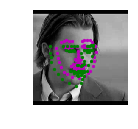

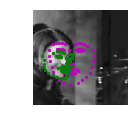

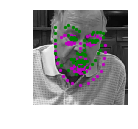

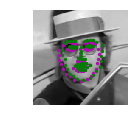

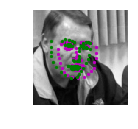

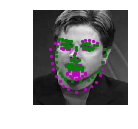

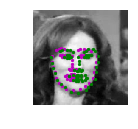

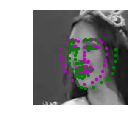

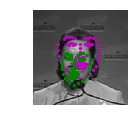

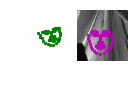

In [99]:
visualize_output(test_images,test_outputs,gt_pts)

### Feature Visualization

(32, 1, 5, 5)
[[ 0.0293921  -0.05735762  0.03693279  0.29160577  0.26281312]
 [-0.05490407  0.05937981  0.01372436  0.17350826  0.0771967 ]
 [-0.19724578 -0.25207448 -0.05594538  0.15941915  0.14983062]
 [-0.12274713 -0.1918108  -0.09651273 -0.09824198  0.10131298]
 [ 0.07026992 -0.27210012 -0.08184437 -0.01328267 -0.17695145]]
(5, 5)


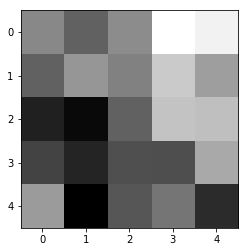

In [111]:
# Get weight in the 1st conv layer 'Conv1'

weights1=model.conv1.weight.data
w=weights1.numpy()
print(w.shape)

filter_index=5
print(w[filter_index][0])
print(w[filter_index][0].shape)


# Display the filter weight
plt.imshow(w[filter_index][0],cmap='gray')

#### Filter an image to see the effect of a convolutional kernel

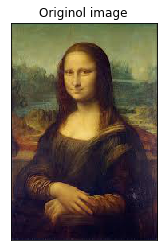

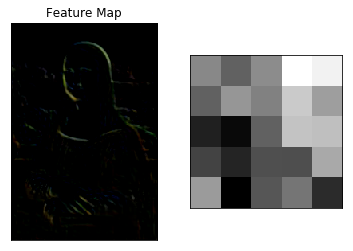

In [112]:
import cv2

# Loading the image
image=cv2.imread('images/mona_lisa.jpg')
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.title('Originol image')

# Applying the image
filtered = cv2.filter2D(image, -1, w[filter_index][0])

# Visualization
fig = plt.figure()
ax = fig.add_subplot(121, xticks = [], yticks = [])
ax.imshow(filtered)
ax.set_title("Feature Map")
ax = fig.add_subplot(122, xticks = [], yticks = [])
ax.imshow(w[filter_index][0], cmap = 'gray')

plt.show()